In [172]:
import Pkg
#Pkg.add("Plots")
#Pkg.add("FFTW")
using Statistics
using Plots
using FFTW

### Fourier collocation

Define Runge-Kutta method

In [1]:
function runge_kutta(w, tn, f, h)
    
    for j = 1:round(Int, tn / h - 1)
        k1 = h * f(w[j])
        k2 = h * f((w[j] + k1) / 2)
        k3 = h * f((w[j] + k2) / 2)
        k4 = h * f(w[j] + k3)
        
        push!(w, w[j] + (k1 + 2 * k2 + 2 * k3 + k4) / 6)
    end
    
    return w
end

runge_kutta (generic function with 1 method)

### Матрица псевдодифференциального оператора.

Матрица Тёплица (диагонально-постоянная матрица) — матрица, в которой на всех диагоналях, параллельных главной, стоят равные элементы `Toeplitz`

In [252]:
function toeplitz(x::AbstractVector{T}) where T
   n = length(x)
   A = zeros(T, n, n)
   for i = 1:n
       for j = 1:n-i+1
           A[i,i+j-1] = x[j]
       end
       for j = n-i+2:n
           A[i, j-(n-i+1)] = x[j]
       end
   end
   return A
end

toeplitz (generic function with 1 method)

Матрица псевдодифференциального оператора `DN_generator`

In [422]:
function DN_generator(N)
    h = 2 * pi / N
    M = [mod(j, N) != 0 ? (-1) ^ (j+1) * cot(j * h / 2) / 2 : 0 for j = 0:(N - 1)]
    DN = transpose.(toeplitz(M))
    return DN
end

DN_generator (generic function with 1 method)

Функция для тестирования матрицы псевододифференциального оператора $f = e^{sin(2x)}$, $f'_x = 2cos(2x)e^{sin(2x)}$, $x \in [0, 2\pi]$.

In [1075]:
M = 50
errors = zeros(M)
N = [i*2 for i=1:M]
for k=1:M
    h = 2 * pi / N[k]
    x = [-pi + i * h for i=1:N[k]]
    f = [exp(sin(2*x[i])) for i = 1:N[k]]
    df = [2*cos(2*x[i]) * exp(sin(2*x[i])) for i = 1:N[k]]
    DN = DN_generator(N[k])
    errors[k] = maximum(abs.(DN * f - df))
end

In [1076]:
plot!(N, errors, seriestype = :scatter, 
    xaxis=:log, yaxis=:log, 
    title = "Convergence of spectral differentiation", 
    legend = false)
xlabel!("number of points")
ylabel!("error")
savefig("сonvergence_spectral_diff.png")

Vector of functions

In [202]:
function func(F)    
    return DN * DN * F   
end

func (generic function with 1 method)

In [197]:
function phi(F)
    return [- k ^ 2 * F[k] / 5 for k=1:length(F)]
end

phi (generic function with 1 method)

In [249]:
N = 100 # number of grid points
DN = DN_generator(N)

x = zeros(N) # points of grid
x = [2 * pi * j / N for j = 1:N]
F0 = [cos(x[i]) for i=1:N] # init cond
Phi0 = [(- 1 / i) * sum([((-1)^(j - 1)) * F0[j] for j=1:i]) for i=1:N]

T = 3 # time
h = ((2 * pi / N) ^ 2) / 5
t = [h * i for i=1:round(Int, T / h)]

println()

Старый алгоритм генерации матрицы (скорее всего содержит ошибку, поскольку не удавалось получить спектральную сходимость)

In [ ]:
N = 10 # number of grid points
DN = zeros(N, N) # pd matrix

DN = [l != j ? (-1) ^ (l + j) * cot((l - j) * pi / N) / 2 : 0 for j = 1:N for l = 1:N]
DN = reshape(DN, N, N) # pseudo-diff matrix

Решение уравнения теплопроводности

In [250]:
FN = runge_kutta([F0], T, func, h)

println()

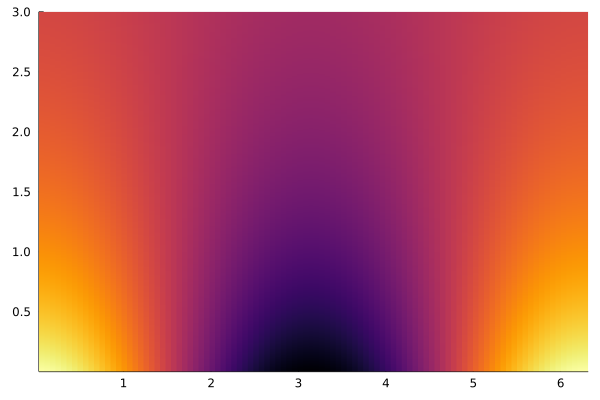

In [251]:
M = reduce(vcat,transpose.(FN))

heatmap(x, t, M, dpi =300)
#savefig("heatmap1.png")

┌ Info: Saved animation to 
│   fn = /home/less_gorelik/julia/tmp.gif
└ @ Plots /home/less_gorelik/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/home/less_gorelik/julia/tmp.gif")
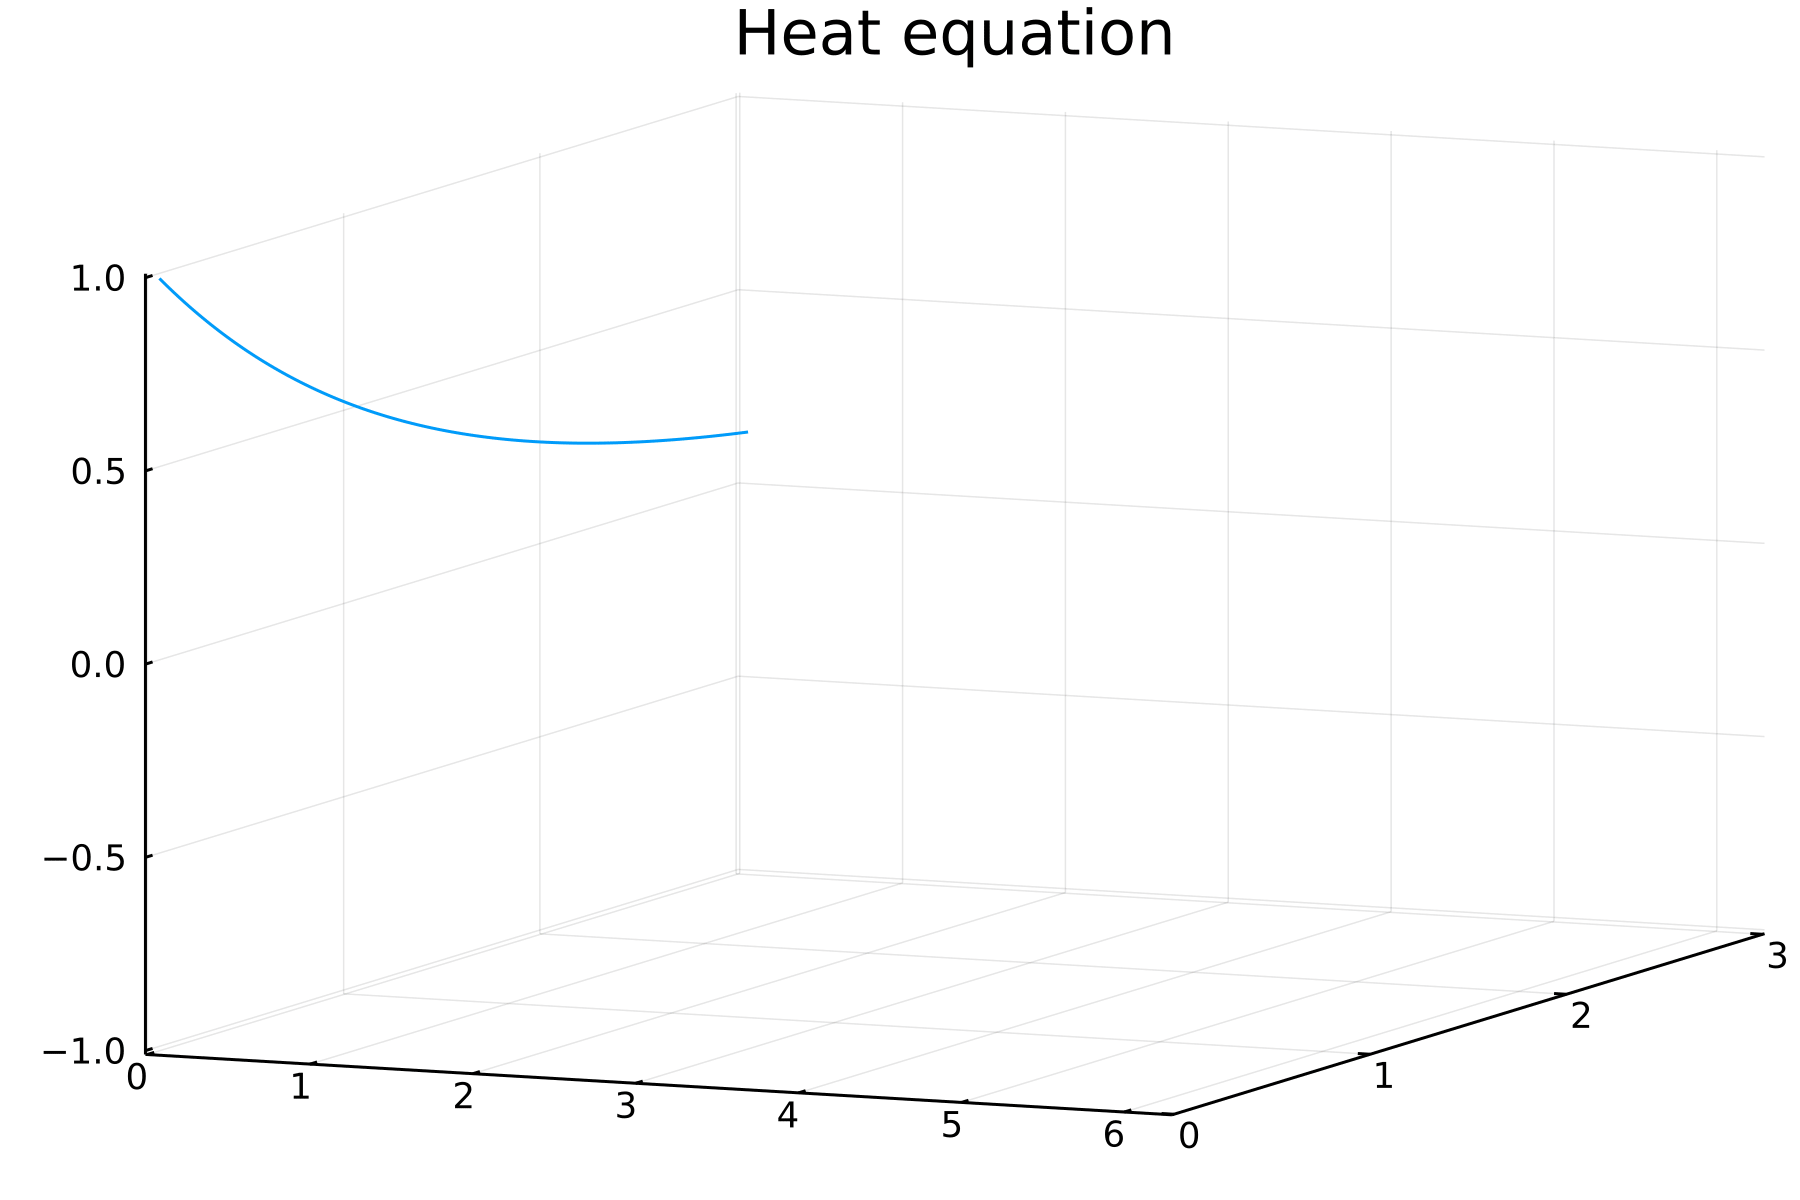

In [254]:
plt = plot3d(
    xlim = (-0.01, 2 * pi + 0.01),
    ylim = (-0.01, T + 0.01),
    zlim = (-1.01, 1.01),
    title = "Heat equation",
    marker = 2,
)

default(legend = false)

@gif for i=1:N
    default(legend = false)
    #push!(plt, [x[i] for j=1:round(Int, T / h)], t, [FN[j][i] for j=1:round(Int, T / h)])
    plot!([x[i] for j=1:round(Int, T / h)], t, [FN[j][i] for j=1:round(Int, T / h)], dpi =300)
end every Int(N / 50)
#savefig("figure1.png")

In [41]:
PN = runge_kutta([rfft(F0)], T, phi, h)

println()

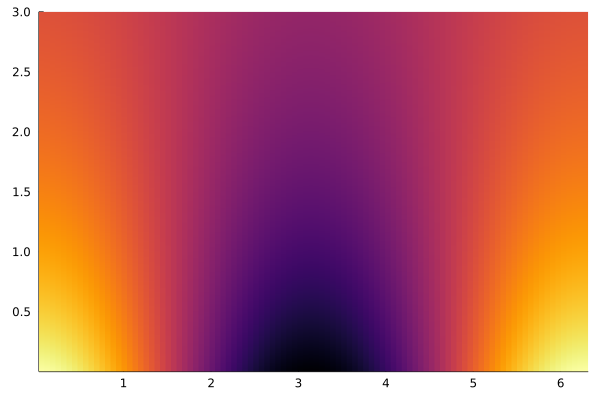

In [51]:
sol = [irfft(PN[i], N) for i=1:length(PN)]
M2 = reduce(vcat,transpose.(sol))
heatmap(x, t, M2, dpi =300)
#plot(ifft(M2))
#savefig("heatmap2.png")

In [38]:
sol = [irfft(PN[i], N) for i=1:length(PN)]

println()

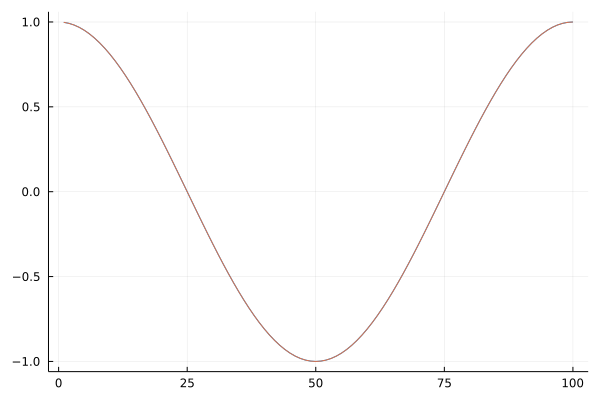

In [50]:
plot(irfft(rfft(F0), N))
plot!(F0)

In [ ]:
plt = plot3d(
    xlim = (-0.01, 2 * pi + 0.01),
    ylim = (-0.01, T + 0.01),
    zlim = (-1.01, 1.01),
    title = "Heat equation",
    marker = 2,
)

default(legend = false)

@gif for i=1:N
    default(legend = false)
    #push!(plt, [x[i] for j=1:round(Int, T / h)], t, [FN[j][i] for j=1:round(Int, T / h)])
    plot!([x[i] for j=1:round(Int, T / h)], t, [sol[j][i] for j=1:round(Int, T / h)], dpi =300)
end every Int(N / 50)
#savefig("figure2.png")

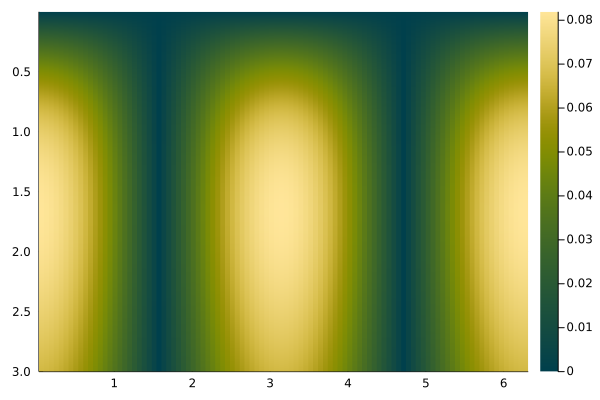

In [80]:
default(legend = true)

heatmap(x, t, broadcast(abs, M - M2),  yflip=true, c = cgrad(:bamako), dpi = 300)

In [81]:
savefig("heatmap3.png")

### Bateman–Burgers equation

In [1107]:
N = 50 # number of grid points
DN = DN_generator(N)

x = zeros(N) # points of grid
x = [2 * pi * j / N for j = 1:N]
F0 = [1/ exp(sin(x[i]))^2 for i=1:N] # init cond
#Phi0 = [(- 1 / i) * sum([((-1)^(j - 1)) * F0[j] for j=1:i]) for i=1:N]

T = 3 # time
h = ((2 * pi / N) ^ 2) / 20
t = [h * i for i=1:round(Int, T / h)]

println()

In [1108]:
DN2 = DN^2
println()

In [1109]:
function g(F)    
    return DN2 * F - F .* (DN * F) 
end

g (generic function with 1 method)

In [1110]:
GN = runge_kutta([F0], T, g, h)

println()

In [1115]:
sol = GN
M2 = reduce(vcat,transpose.(sol))
heatmap(x, t, M2, dpi =300)
#plot(ifft(M2))
savefig("heatmap_BB.png")

In [1112]:
minimum(minimum(GN))

0.13587044509581664

In [1113]:
maximum(maximum(GN))

4.352974227499481

In [1114]:
plt = plot3d(
    xlim = (-0.01, 2 * pi + 0.01),
    ylim = (-0.01, T + 0.01),
    zlim = (0, 5),
    title = "Bateman–Burgers equation",
    marker = 2,
)

default(legend = false)

@gif for i=1:N
    default(legend = false)
    #push!(plt, [x[i] for j=1:round(Int, T / h)], t, [FN[j][i] for j=1:round(Int, T / h)])
    plot!([x[i] for j=1:round(Int, T / h)], t, [GN[j][i] for j=1:round(Int, T / h)], dpi =300)
end every Int(N / 50)
savefig("figure_BB.png")

┌ Info: Saved animation to 
│   fn = /home/less_gorelik/julia/tmp.gif
└ @ Plots /home/less_gorelik/.julia/packages/Plots/8K4be/src/animation.jl:114


### Kuramoto–Sivashinsky equation

In [538]:
DN_generator(N) ^ 4

50×50 Matrix{Any}:
  70520.8   -54466.7    25959.8   …   -8799.58   25959.8   -54466.7
 -54466.7    70520.8   -54466.7        1917.15   -8799.58   25959.8
  25959.8   -54466.7    70520.8        1421.44    1917.15   -8799.58
  -8799.58   25959.8   -54466.7       -3274.79    1421.44    1917.15
   1917.15   -8799.58   25959.8        4405.07   -3274.79    1421.44
   1421.44    1917.15   -8799.58  …   -5143.08    4405.07   -3274.79
  -3274.79    1421.44    1917.15       5650.35   -5143.08    4405.07
   4405.07   -3274.79    1421.44      -6013.16    5650.35   -5143.08
  -5143.08    4405.07   -3274.79       6280.89   -6013.16    5650.35
   5650.35   -5143.08    4405.07      -6483.45    6280.89   -6013.16
  -6013.16    5650.35   -5143.08  …    6639.78   -6483.45    6280.89
   6280.89   -6013.16    5650.35      -6762.33    6639.78   -6483.45
  -6483.45    6280.89   -6013.16       6859.56   -6762.33    6639.78
      ⋮                           ⋱                        
  -6483.45    6639.78   -6

In [579]:
M = 50
errors = zeros(M)
N = [i*2 for i=1:M]
for k=1:M
    h = 2 * pi / N[k]
    x = [-pi + i * h for i=1:N[k]]
    f = [exp(2 * sin(x[i])) for i = 1:N[k]]
    df = [(8 * cos(x[i])^3 - 6 * sin(2*x[i]) - 2*cos(x[i])) * exp(2 * sin(x[i])) for i = 1:N[k]]
    DN = DN_generator(N[k])
    errors[k] = maximum(abs.(DN^3 * f - df))
end

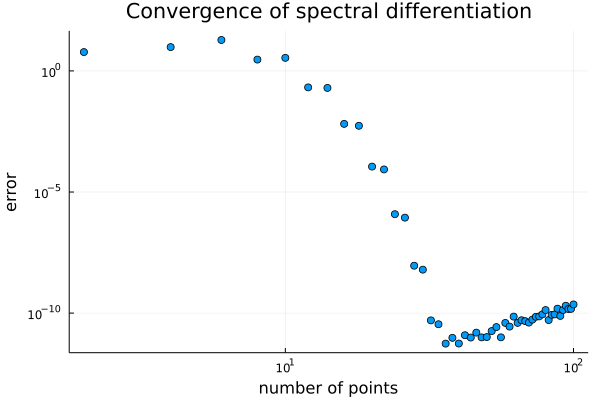

In [580]:
plot(N, errors, seriestype = :scatter, 
    xaxis=:log, yaxis=:log, 
    title = "Convergence of spectral differentiation", 
    legend = false)
xlabel!("number of points")
ylabel!("error")

In [1077]:
N = 40 # number of grid points
DN = DN_generator(N)

x = zeros(N) # points of grid
x = [2 * pi * j / N for j = 1:N]
F0 = [exp(sin(x[i])) for i=1:N] # init cond

T = 0.5 # time
h = ((2 * pi / N) ^ 2) / 70
t = [h * i for i=1:round(Int, T / h)]

println()

In [1078]:
DN2 = DN^2
DN3 = DN^3
DN4 = DN^4
println()

In [1089]:
function g(F)    
    return  - (DN3 + DN2) * F - F .* DN * F
end

g (generic function with 1 method)

In [1090]:
GN = runge_kutta([F0], T, g, h)

println()

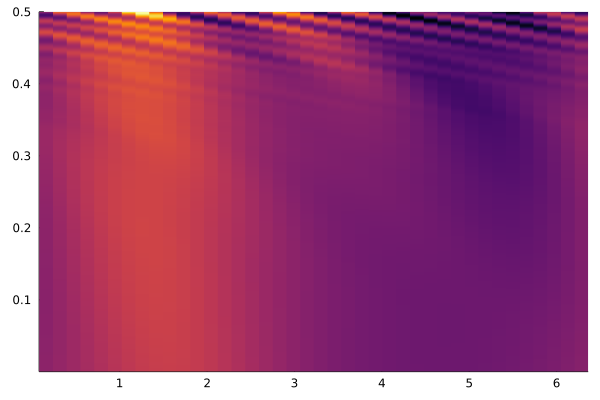

In [1091]:
sol = GN
M2 = reduce(vcat,transpose.(sol))
heatmap(x, t, M2, dpi =300)
#plot(ifft(M2))
#savefig("heatmap2.png")

In [1088]:
minimum(minimum(GN))

-2.1878327999522013e248

In [1071]:
maximum(maximum(GN))

3.846963250072091

In [1072]:
GN

570-element Vector{Vector{Float64}}:
 [1.2311044469213748, 1.5019085155664522, 1.7999974573044333, 2.1025372410974477, 2.3774426752361646, 2.5884429473328665, 2.70343150912349, 2.7034315091234906, 2.588442947332867, 2.377442675236165  …  0.3863326410305472, 0.3699002532985277, 0.36990025329852766, 0.3863326410305472, 0.4206200260541148, 0.47561583236358596, 0.5555563403392463, 0.6658195153936157, 0.8122787652182577, 0.9999999999999989]
 [1.230381887269183, 1.501742619479337, 1.800580933189454, 2.103902696801031, 2.3793971213294816, 2.5905921476415514, 2.705304926958538, 2.704656423913758, 2.5888787732617864, 2.377205195282798  …  0.38625268835943416, 0.3697345189849266, 0.3696318451614121, 0.3859402750141379, 0.42007937326508327, 0.47490520563517663, 0.5546683570930611, 0.6647795390364764, 0.8111675397250766, 0.998971389201275]
 [1.229655533195525, 1.501579176856308, 1.801174074887444, 2.105282185612376, 2.381364096947167, 2.592746562318466, 2.70717392126325, 2.705869949552548, 2.58930